DataSet : https://www.kaggle.com/alxmamaev/flowers-recognition

# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision import models
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Loading the data

In [ ]:
data_dir = '/content/drive/MyDrive/FlowersRecognisation_Project/flowers'

import os

os.listdir(data_dir)

# Now we have all the right categories 

print("Labels => ",os.listdir(data_dir))

# No. of images in each labels 

print("\nNo. of images in each labels => ")
for cls in os.listdir(data_dir):
  print([cls, ":" , len(os.listdir(data_dir+ '/' + cls))])

Labels =>  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

No. of images in each labels => 
['daisy', ':', 769]
['dandelion', ':', 1055]
['rose', ':', 784]
['sunflower', ':', 734]
['tulip', ':', 984]


In [ ]:
dataset = ImageFolder(data_dir)   # Pointed the ImageFolder to all the sub folders (Categories)
print("Dataset Length: ", len(dataset))
print("Classes: ",dataset.classes)
print("A Perticular Element: ",dataset[0])

Dataset Length:  4323
Classes:  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
A Perticular Element:  (<PIL.Image.Image image mode=RGB size=320x263 at 0x7EFC4251C828>, 0)


# GPU

In [ ]:
# Move our model and data to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Chech for GPU availablity

import torch
print("Check for GPU Availability: ",torch.cuda.is_available())

device = get_default_device()
device

Check for GPU Availability:  True


device(type='cuda')

# Model 

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(dataset.classes),pretrained=True), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

# Transforming the images

In [ ]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir , 
                      tt.Compose([tt.Resize(img_size), 
                                  tt.RandomCrop(img_size),
                                  tt.ToTensor(),
                                  tt.Normalize(*imagenet_stats)]))

In [ ]:
val_per = 0.1
val_size = int(val_per * len(dataset))
train_size = len(dataset) - val_size

                                  #Data        #Size
train_ds,valid_ds = random_split(dataset, [train_size,val_size])

print("Train Size: ",len(train_ds) ," |  Validation Size: ",len(valid_ds) )

batch_size=64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model,valid_dl)]
history

[{'val_acc': 0.2485119104385376, 'val_loss': 2.2234551906585693}]

In [ ]:
history+= fit_one_cycle(3,
                0.001,
                model,
                train_dl,
                valid_dl,
                weight_decay=0.01,
                grad_clip=0.1,
                opt_func=torch.optim.Adam)


Epoch [0], train_loss: 0.3793, val_loss: 1.1388, val_acc: 0.6399



Epoch [1], train_loss: 0.5510, val_loss: 0.5855, val_acc: 0.8110



Epoch [2], train_loss: 0.3145, val_loss: 0.4484, val_acc: 0.8497


In [ ]:
history += fit_one_cycle(5,
              0.001,
              model,
              train_dl,
              valid_dl,
              weight_decay=0.01,
              grad_clip=0.1,
              opt_func=torch.optim.Adam)


Epoch [0], train_loss: 0.3012, val_loss: 0.8719, val_acc: 0.6979



Epoch [1], train_loss: 0.5788, val_loss: 0.7675, val_acc: 0.7307



Epoch [2], train_loss: 0.5231, val_loss: 0.7106, val_acc: 0.7344



Epoch [3], train_loss: 0.3927, val_loss: 0.5438, val_acc: 0.7909



Epoch [4], train_loss: 0.2553, val_loss: 0.5594, val_acc: 0.8036


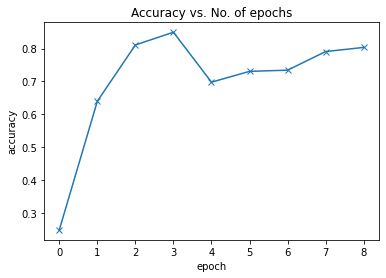

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

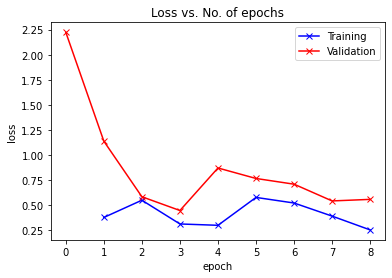

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

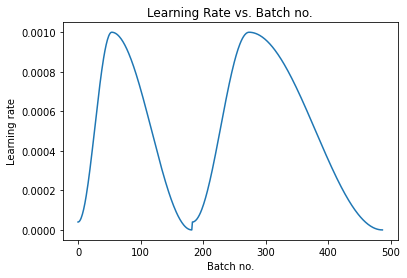

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

Denormalize function helps us to make predictions on actual images 

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)


In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Label: rose (2)
tulip


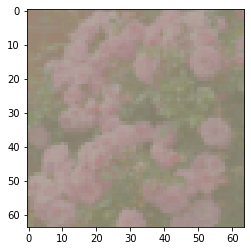

In [ ]:
img,label = valid_ds[100]
show_image(img,label)
pred = predict_image(img,model,dataset.classes)
print(pred)

Saving the model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FlowersRecognisation_Project/flowers-resnet34.pth')